In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create a File Path and list all of the files in that folder.

In [2]:
import os

#path to the folder where my pkl files are located on Google Drive
folder_path = '/content/drive/My Drive/Colab Notebooks/DL assignment/train'

#list of all files in that folder
file_list = os.listdir(folder_path)

#print the list of pkl files to see if it works
print(file_list)


['21259.pkl', '21248.pkl', '21262.pkl', '21268.pkl', '21244.pkl', '21275.pkl', '21264.pkl', '21252.pkl', '21272.pkl', '21246.pkl', '21265.pkl', '21271.pkl', '21251.pkl', '21267.pkl', '21238.pkl', '21236.pkl', '21245.pkl', '21281.pkl', '21326.pkl', '21319.pkl', '21298.pkl', '21303.pkl', '21314.pkl', '21305.pkl', '21296.pkl', '21286.pkl', '21317.pkl', '21310.pkl', '21325.pkl', '21318.pkl', '21316.pkl', '21294.pkl', '21297.pkl', '21292.pkl', '21324.pkl', '21295.pkl', '21307.pkl', '21304.pkl', '21322.pkl', '21288.pkl', '21320.pkl', '21291.pkl', '21323.pkl', '21285.pkl', '21283.pkl', '21287.pkl', '21293.pkl', '21300.pkl', '21329.pkl', '21313.pkl', '21327.pkl', '21306.pkl', '21280.pkl', '21289.pkl', '21311.pkl', '21321.pkl', '21290.pkl', '21312.pkl', '21308.pkl', '21299.pkl', '21368.pkl', '21374.pkl', '21337.pkl', '21353.pkl', '21370.pkl', '21359.pkl', '21343.pkl', '21364.pkl', '21339.pkl', '21342.pkl', '21348.pkl', '21344.pkl', '21360.pkl', '21341.pkl', '21362.pkl', '21340.pkl', '21351.pkl'

#Create Mel-spectograms out of all audio files.

In [3]:
import torch
import torchaudio.transforms as T
import os
import pickle

#Set up the Mel-spectrogram transform
n_fft = 2048  #The size of the FFT, which will also determine the number of frequency bins
n_mels = 128  #The number of Mel bands
hop_length = 512  #The hop length between slices
sample_rate = 8000  #The sample rate of the audio files

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

#Function to convert audio to Mel-spectrogram
def audio_to_mel(audio):
    audio_tensor = torch.tensor(audio).float()
    mel_spec = mel_spectrogram(audio_tensor)
    return mel_spec

#Function to load a single pkl file
def load_pkl(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

#Initialize a list to hold all the data
all_data = []

#Processing each .pkl file
for file_name in file_list:
    #Load the audio and valence from the pkl file
    data = load_pkl(os.path.join(folder_path, file_name))

    #Extract the audio data
    audio_data = data['audio_data']

    #Convert the audio to a Mel-spectrogram
    mel_spec = audio_to_mel(audio_data)

    #Store the Mel-spectrogram and valence in the list
    all_data.append((mel_spec, data['valence']))




In [4]:
#I had some problems with different training the LSTM on the spectrograms - due to a disreptancy in mel-bands among spectrograms
def adjust_mel_specs(data, target_n_mels=128):
    adjusted_data = []
    for mel_spec, valence in data:
        if mel_spec.shape[1] != target_n_mels:
            if mel_spec.shape[1] > target_n_mels:
                #Truncate the excess Mel bands
                adjusted_mel_spec = mel_spec[:, :target_n_mels]
            else:
                #Zero-pad the Mel spectrogram to the right to reach target_n_mels
                padding_size = target_n_mels - mel_spec.shape[1]
                padding = torch.zeros((mel_spec.shape[0], padding_size), dtype=mel_spec.dtype)
                adjusted_mel_spec = torch.cat([mel_spec, padding], dim=1)
            adjusted_data.append((adjusted_mel_spec, valence))
        else:
            adjusted_data.append((mel_spec, valence))
    return adjusted_data

#Apply the adjustment to your dataset
all_data = adjust_mel_specs(all_data)


#Verification code
def verify_adjusted_mel_specs(data):
    for idx, (mel_spec, valence) in enumerate(data):
        assert mel_spec.shape[1] == 128, f"Mel spectrogram at index {idx} does not have 128 Mel bands."

verify_adjusted_mel_specs(all_data)
print("All Mel spectrograms have been successfully adjusted to 128 Mel bands.") #seems like the spectrograms are all equal in Mel bands now!


All Mel spectrograms have been successfully adjusted to 128 Mel bands.


#Visualize Spectrograms

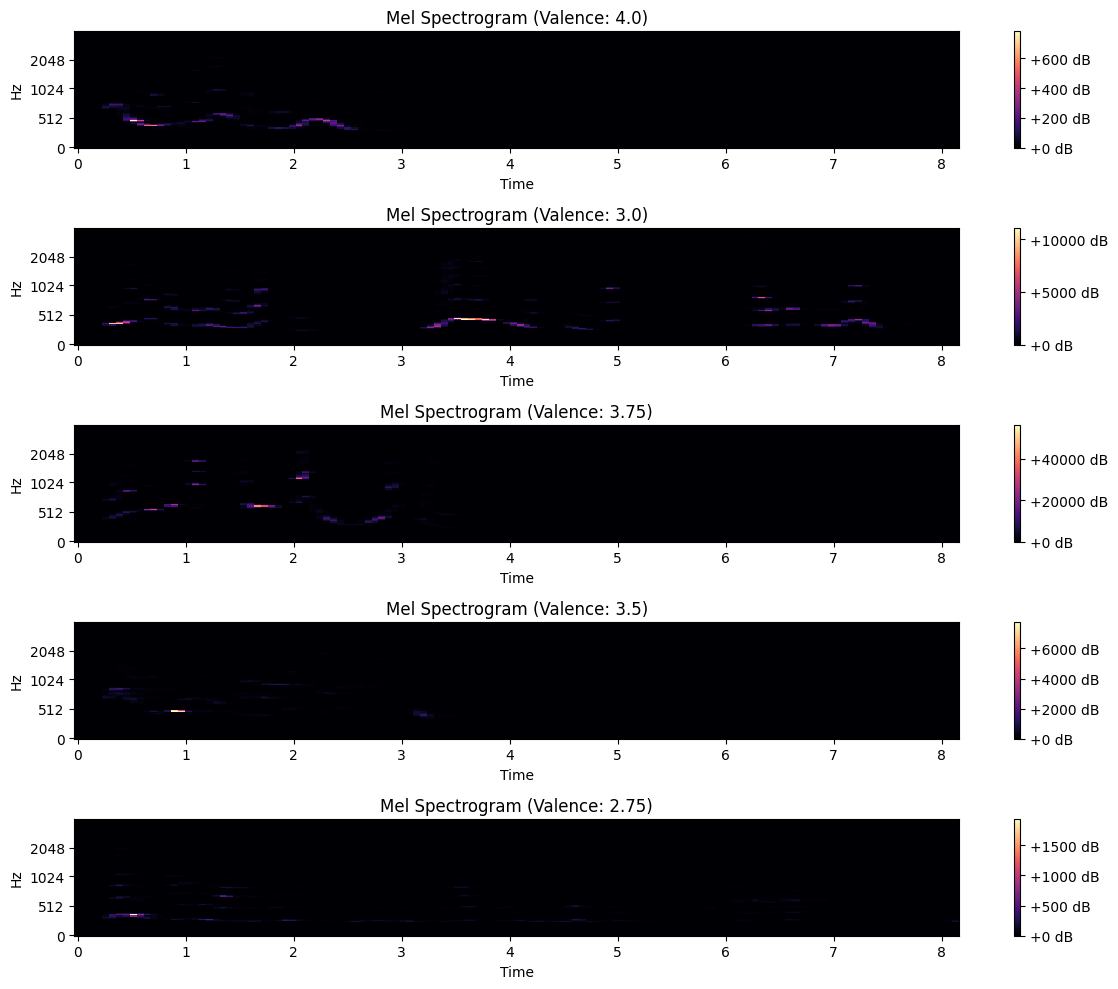

In [5]:
#in order to find out what the best preprocessing steps would be
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch

#Taking just the first 5 spectrograms
sample_data = all_data[:5]

#Function to display Mel spectrograms
def display_mel_spectrograms(data, sr=8000):
    fig, axes = plt.subplots(nrows=len(data), figsize=(12, 10))
    if len(data) == 1:
        axes = [axes]

    for ax, (mel_spec, valence) in zip(axes, data):
        #Check if mel_spec is a tensor and convert it to numpy if it is
        if isinstance(mel_spec, torch.Tensor):
            mel_spec = mel_spec.numpy()

        #If mel_spec is two-dimensional (features over time), display it
        if mel_spec.ndim == 2:
            img = librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', ax=ax, fmax=sr//2)
            ax.set(title=f'Mel Spectrogram (Valence: {valence})')
            fig.colorbar(img, ax=ax, format="%+2.f dB")

    plt.tight_layout()
    plt.show()

#Display the Mel spectrograms for the sample data
display_mel_spectrograms(sample_data)

#Based on the first 5 entries, it is clear that the spectrograms vary a lot in length



# Model Architecture: LSTM

In [6]:
import torch
import torch.nn as nn

#Based off of the knowledge in week 10's module, we thought it would be wise to try out an LSTM model for sequence data like in this task.


class ValencePredictor(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=1, output_size=1, bidirectional=False):
        super(ValencePredictor, self).__init__()
        self.bidirectional = bidirectional  #Store the bidirectional setting as an instance variable
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)  #Use the bidirectional parameter here

        #Adjust the input feature size of the fully connected layer if LSTM is bidirectional
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * factor, output_size)  # Double the hidden_size if bidirectional

    def forward(self, x, seq_lengths):
        #Pack the padded sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_input)

        #Handling the LSTM output for bidirectional/unidirectional cases
        if self.bidirectional:
            #Concatenate the hidden states of the last layer for both directions
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            #Use the hidden state of the last layer (last time step)
            hidden = hidden[-1, :, :]

        #Pass the output of LSTM to the fully connected layer
        output = self.fc(hidden)
        return output


#Split Data

In [7]:
from sklearn.model_selection import train_test_split

#80/20 split
train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=42)


# Create a DataLoader with a custom collate function.

In [8]:
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn.utils.rnn import pad_sequence

class MelSpectrogramDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



def collate_fn(batch):
    sequences = [torch.tensor(seq, dtype=torch.float32) for seq, _ in batch]
    valences = torch.tensor([val for _, val in batch], dtype=torch.float32).unsqueeze(1)

    #Compute the lengths of each sequence before padding
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)

    #Pad sequences to have the same length
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)

    return sequences_padded, valences, lengths



train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)



#Quick test to confirm DataLoader functionality
try:
    for mel_specs, valences in train_loader:
        print("Batch shapes:", mel_specs.shape, valences.shape)
        break  # Test only the first batch
    print("DataLoader works fine!")
except Exception as e:
    print("Error in DataLoader:", e)


Error in DataLoader: too many values to unpack (expected 2)


<ipython-input-8-0d573acd4eb6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq, _ in batch]


# Create Loss function and optimizer

In [ ]:
import torch.optim as optim

model = ValencePredictor()  #LSTM model
criterion = torch.nn.MSELoss()  #Mean-Squared Error loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  #Adam Optimzer



# Set up a Cuda Device


In [ ]:
import torch

#Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Move the model to the chosen device
model.to(device)


#May or may not use this later


Using device: cpu


ValencePredictor(
  (encoder): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

# Train the model

In [ ]:
#Define the number of epochs
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for mel_specs, valences, lengths in train_loader:
        mel_specs, valences, lengths = mel_specs.to(device), valences.to(device), lengths.to(device)

        optimizer.zero_grad()  #Clear gradients for this training step
        outputs = model(mel_specs, lengths)  #Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, valences)  #Calculate the loss
        loss.backward()  #Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  #Perform a single optimization step

        total_train_loss += loss.item() * mel_specs.size(0)  #Aggregate the loss

    #Calculate average loss over the training data
    avg_train_loss = total_train_loss / len(train_loader.dataset)

    #Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for mel_specs, valences, lengths in val_loader:
            mel_specs, valences, lengths = mel_specs.to(device), valences.to(device), lengths.to(device)
            outputs = model(mel_specs, lengths)
            val_loss = criterion(outputs, valences)
            total_val_loss += val_loss.item() * mel_specs.size(0)  #Aggregate the validation loss

    #Calculate average loss over the validation data
    avg_val_loss = total_val_loss / len(val_loader.dataset)

    print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')



<ipython-input-52-ffcaa1265749>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq, _ in batch]


Epoch 1: Training Loss: 0.6540, Validation Loss: 0.6529
Epoch 2: Training Loss: 0.6325, Validation Loss: 0.6705
Epoch 3: Training Loss: 0.6044, Validation Loss: 0.6536
Epoch 4: Training Loss: 0.5815, Validation Loss: 0.6603
Epoch 5: Training Loss: 0.5441, Validation Loss: 0.7104
Epoch 6: Training Loss: 0.5270, Validation Loss: 0.6753
Epoch 7: Training Loss: 0.5003, Validation Loss: 0.7056
Epoch 8: Training Loss: 0.4803, Validation Loss: 0.6873
Epoch 9: Training Loss: 0.4598, Validation Loss: 0.6999
Epoch 10: Training Loss: 0.4439, Validation Loss: 0.7650
Epoch 11: Training Loss: 0.4256, Validation Loss: 0.6985
Epoch 12: Training Loss: 0.4101, Validation Loss: 0.7298
Epoch 13: Training Loss: 0.3952, Validation Loss: 0.7033
Epoch 14: Training Loss: 0.3717, Validation Loss: 0.7260
Epoch 15: Training Loss: 0.3607, Validation Loss: 0.7118
Epoch 16: Training Loss: 0.3420, Validation Loss: 0.7309
Epoch 17: Training Loss: 0.3309, Validation Loss: 0.7484
Epoch 18: Training Loss: 0.3107, Validat

# Evaluate on the Validation set


In [ ]:
import torch

#Ensure the model is in evaluation mode
model.eval()

#Prepare to collect predictions and actuals
predictions = []
actuals = []

#Evaluate on the validation set
with torch.no_grad():
    for mel_specs, valences, lengths in val_loader:
        mel_specs, valences, lengths = mel_specs.to(device), valences.to(device), lengths.to(device)

        #Forward pass to get outputs
        outputs = model(mel_specs, lengths)

        #Store predictions and actuals
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(valences.view(-1).tolist())

#Calculate the evaluation metric
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actuals, predictions)

print(f"Mean Squared Error on the Validation Set: {mse:.4f}")


<ipython-input-52-ffcaa1265749>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq, _ in batch]


Mean Squared Error on the Validation Set: 0.7536


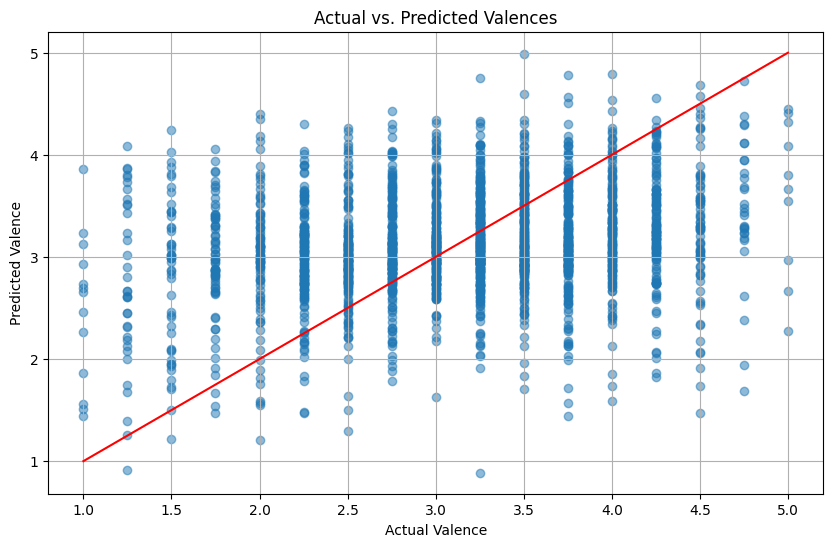

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Valences')
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r')  # A reference line for perfect predictions
plt.grid(True)
plt.show()
